# NLP Mini Project

### Project Description
This is a natural language processing classification challenge focused on disaster tweets. The goal is to build a machine learning model that can predict whether a tweet is about a real disaster (1) or not (0). This is an important application for emergency response organizations and news agencies who need to monitor social media for real disasters.
The main challenge lies in distinguishing between tweets that literally describe disasters versus those that use disaster-related words metaphorically or in other non-literal contexts (like the example of "ABLAZE" being used metaphorically rather than describing an actual fire).

### Dataset Description
The dataset consists of approximately 10,000 tweets that have been hand-classified. Based on the competition page, here's what you can expect in the data:

Train/Test Split: The data will be divided into training and test sets
Labels: Binary classification (1 = real disaster, 0 = not a real disaster)
Text: The actual tweet content
Potentially other metadata: Like tweet ID, location, keywords, etc.

### Approach Suggestions
For this NLP project, you might want to consider:

Text preprocessing: Cleaning tweets (removing URLs, usernames, special characters)
Feature extraction: Using techniques like TF-IDF, word embeddings (Word2Vec, GloVe), or contextual embeddings (BERT, RoBERTa)
Model selection: Trying different classifiers (Logistic Regression, Random Forest, or neural networks)
Evaluation: Using metrics like accuracy, precision, recall, and F1-score

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import pickle
from collections import Counter
import time

In [2]:
plt.style.use('ggplot')
sns.set(style='whitegrid')

In [3]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

Training set shape: (7613, 5)
Test set shape: (3263, 4)


In [4]:
print("\nFirst few rows of the training dataset:")
display(train_df.head())

# Check the data types of columns
print("\nData types:")
print(train_df.dtypes)

# Check for missing values
print("\nMissing values in training set:")
print(train_df.isnull().sum())

print("\nMissing values in test set:")
print(test_df.isnull().sum())


First few rows of the training dataset:


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1



Data types:
id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

Missing values in training set:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Missing values in test set:
id             0
keyword       26
location    1105
text           0
dtype: int64


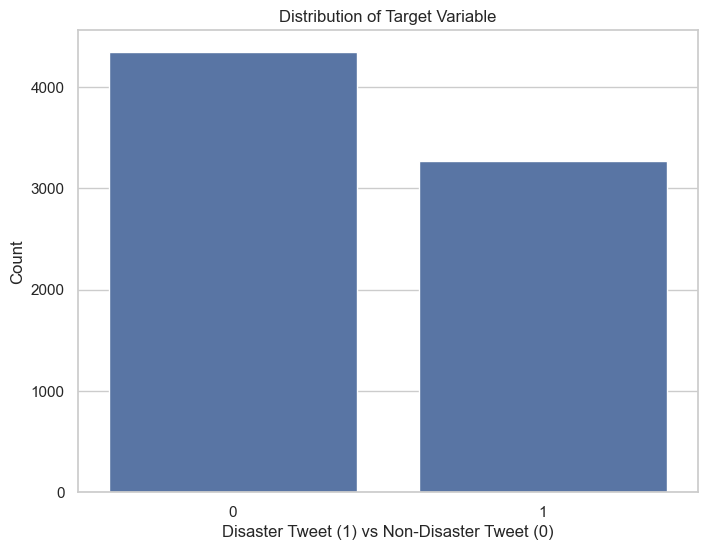

In [5]:
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Target Variable')
plt.xlabel('Disaster Tweet (1) vs Non-Disaster Tweet (0)')
plt.ylabel('Count')
plt.show()

In [6]:
disaster_percentage = train_df['target'].mean() * 100
non_disaster_percentage = 100 - disaster_percentage

print(f"\nDisaster tweets: {disaster_percentage:.2f}%")
print(f"Non-disaster tweets: {non_disaster_percentage:.2f}%")


Disaster tweets: 42.97%
Non-disaster tweets: 57.03%


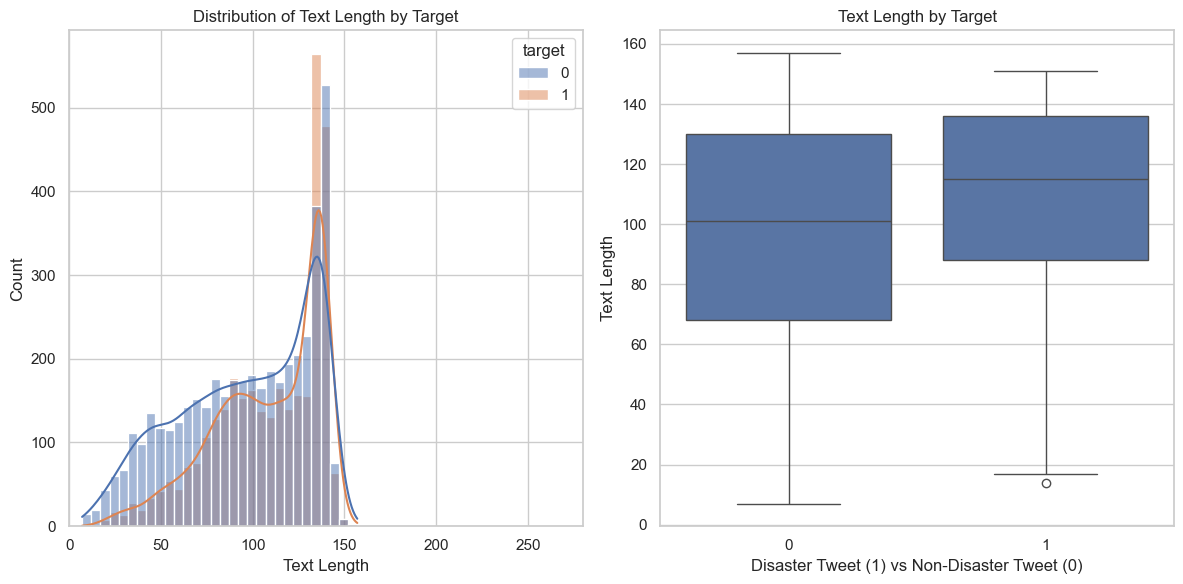

In [7]:
train_df['text_length'] = train_df['text'].apply(len)
test_df['text_length'] = test_df['text'].apply(len)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=train_df, x='text_length', hue='target', bins=30, kde=True)
plt.title('Distribution of Text Length by Target')
plt.xlabel('Text Length')
plt.xlim(0, 280)  # Twitter's character limit

plt.subplot(1, 2, 2)
sns.boxplot(data=train_df, x='target', y='text_length')
plt.title('Text Length by Target')
plt.xlabel('Disaster Tweet (1) vs Non-Disaster Tweet (0)')
plt.ylabel('Text Length')
plt.tight_layout()
plt.show()

This figure displays two visualizations related to text length distribution in the disaster tweet classification dataset:

1. **Left plot (Histogram with KDE)**: Shows the distribution of text length for both disaster (orange) and non-disaster (blue) tweets. There's a clear peak around 140-150 characters, which corresponds to Twitter's original character limit. We can observe that:
   - Both classes follow a similar distribution pattern
   - Disaster tweets (orange line) tend to be slightly longer on average
   - Non-disaster tweets show more variation at shorter lengths (under 100 characters)

2. **Right plot (Box plot)**: Provides a statistical summary of text length by class, confirming that:
   - Disaster tweets (1) have a higher median length (~115 characters) compared to non-disaster tweets (0) (~100 characters)
   - Both classes have similar maximum lengths (around 150-160 characters)
   - The interquartile range (box height) is larger for non-disaster tweets, indicating greater variability
   - Both classes have some outliers at the lower end

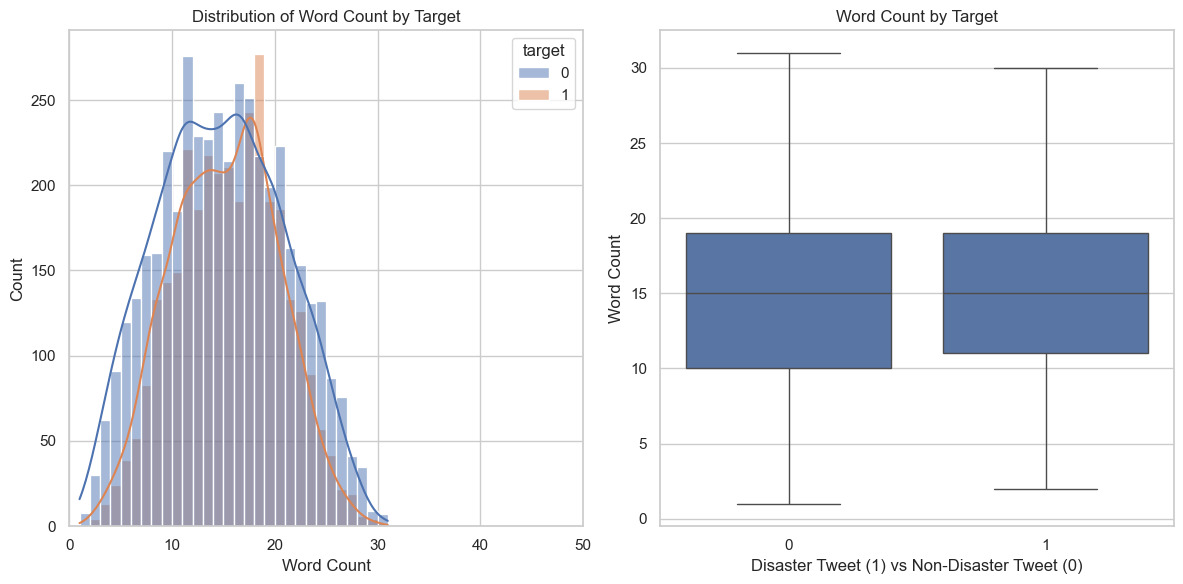

In [8]:
# Word count analysis
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=train_df, x='word_count', hue='target', bins=30, kde=True)
plt.title('Distribution of Word Count by Target')
plt.xlabel('Word Count')
plt.xlim(0, 50)

plt.subplot(1, 2, 2)
sns.boxplot(data=train_df, x='target', y='word_count')
plt.title('Word Count by Target')
plt.xlabel('Disaster Tweet (1) vs Non-Disaster Tweet (0)')
plt.ylabel('Word Count')
plt.tight_layout()
plt.show()

This compares word count distribution between disaster and non-disaster tweets:

1. **Left plot (Histogram with KDE)**: The distribution of word counts shows:
   - Most tweets contain between 5-25 words
   - Non-disaster tweets (blue line) tend to peak around 10-12 words
   - Disaster tweets (orange line) have their highest peak around 16-17 words
   - There's a noticeable difference in the distribution shapes, with disaster tweets skewing toward higher word counts

2. **Right plot (Box plot)**: Provides statistical summary of word counts:
   - Both classes have similar median word counts (approximately 15 words)
   - The interquartile ranges (box heights) are similar
   - Maximum word counts extend to around 30 words for both classes
   - The distributions appear more similar than in the histogram view, suggesting subtler differences

In [9]:
# Define a simple preprocessing function
def initial_preprocess(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Remove user @ references and '#' from tweet
        text = re.sub(r'\@\w+|\#', '', text)
        
        # Remove punctuations and numbers
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        
        # Remove extra whitespace
        text = ' '.join(text.split())
        
        return text
    else:
        return ''
    
train_df['processed_text'] = train_df['text'].apply(initial_preprocess)
test_df['processed_text'] = test_df['text'].apply(initial_preprocess)

In [10]:
def get_common_words(text_series, n=20):
    all_words = ' '.join([str(text) for text in text_series if isinstance(text, str)]).split()
    counter = Counter(all_words)
    return counter.most_common(n)

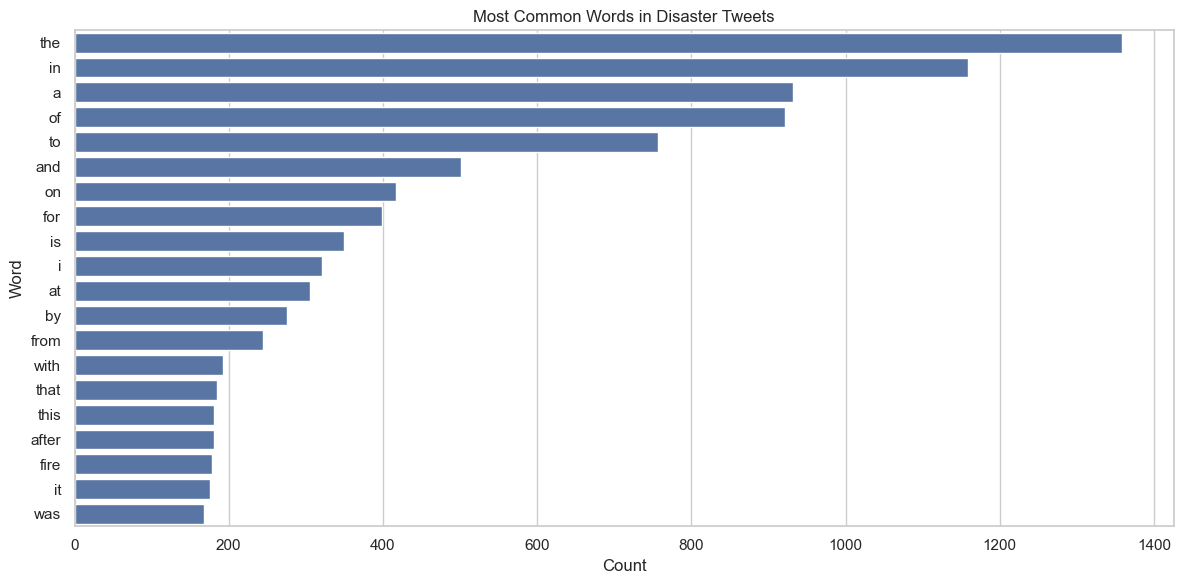

In [11]:
disaster_tweets = train_df[train_df['target'] == 1]['processed_text']
non_disaster_tweets = train_df[train_df['target'] == 0]['processed_text']

disaster_common_words = get_common_words(disaster_tweets)
disaster_words_df = pd.DataFrame(disaster_common_words, columns=['word', 'count'])

plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='word', data=disaster_words_df)
plt.title('Most Common Words in Disaster Tweets')
plt.xlabel('Count')
plt.ylabel('Word')
plt.tight_layout()
plt.show()

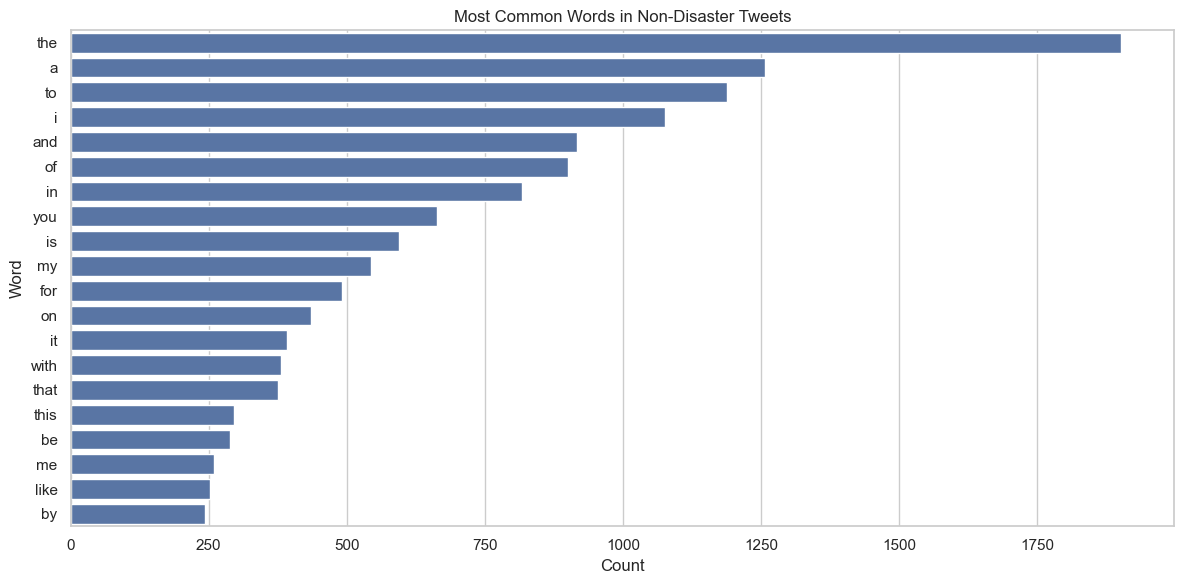

In [12]:
non_disaster_common_words = get_common_words(non_disaster_tweets)
non_disaster_words_df = pd.DataFrame(non_disaster_common_words, columns=['word', 'count'])

plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='word', data=non_disaster_words_df)
plt.title('Most Common Words in Non-Disaster Tweets')
plt.xlabel('Count')
plt.ylabel('Word')
plt.tight_layout()
plt.show()


Number of unique keywords: 221
Top 20 keywords:


keyword
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
collided       40
siren          40
twister        40
windstorm      40
sinkhole       39
sunk           39
hellfire       39
weapon         39
weapons        39
famine         39
Name: count, dtype: int64

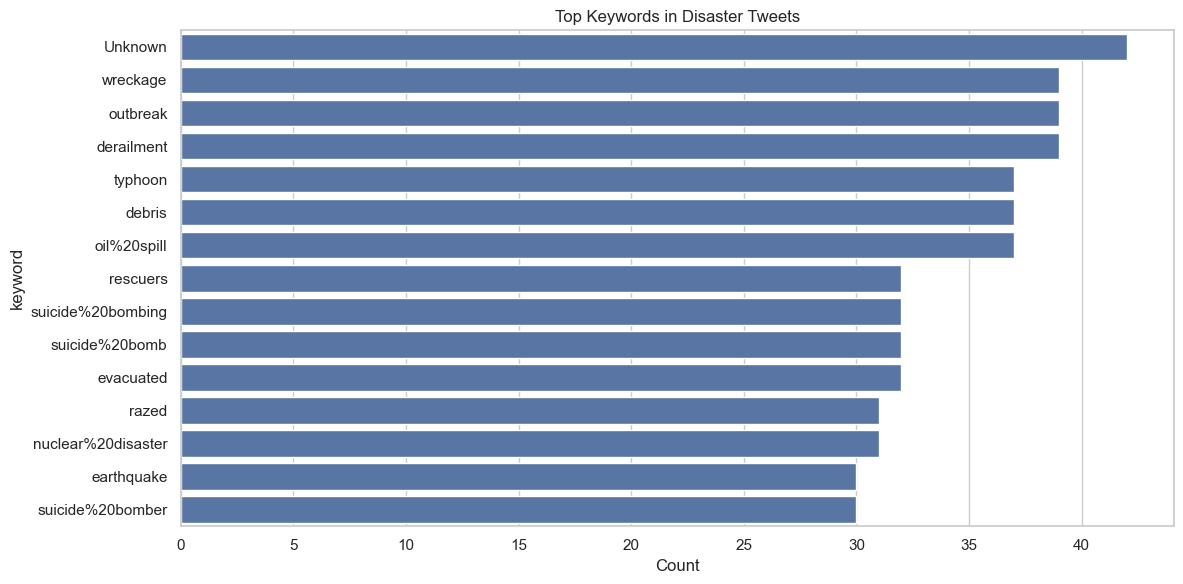

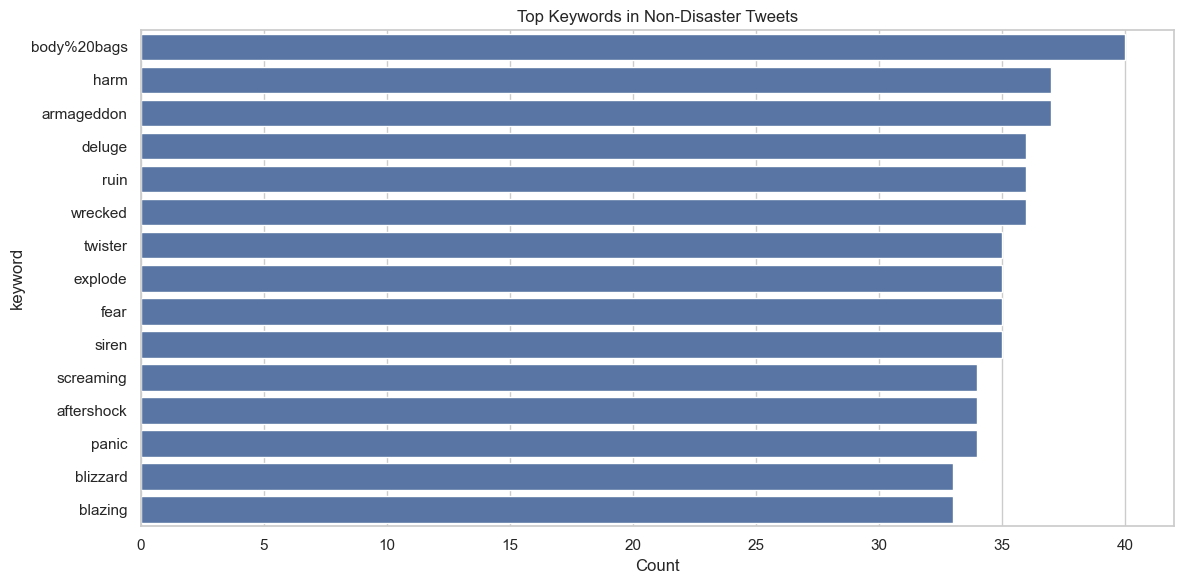

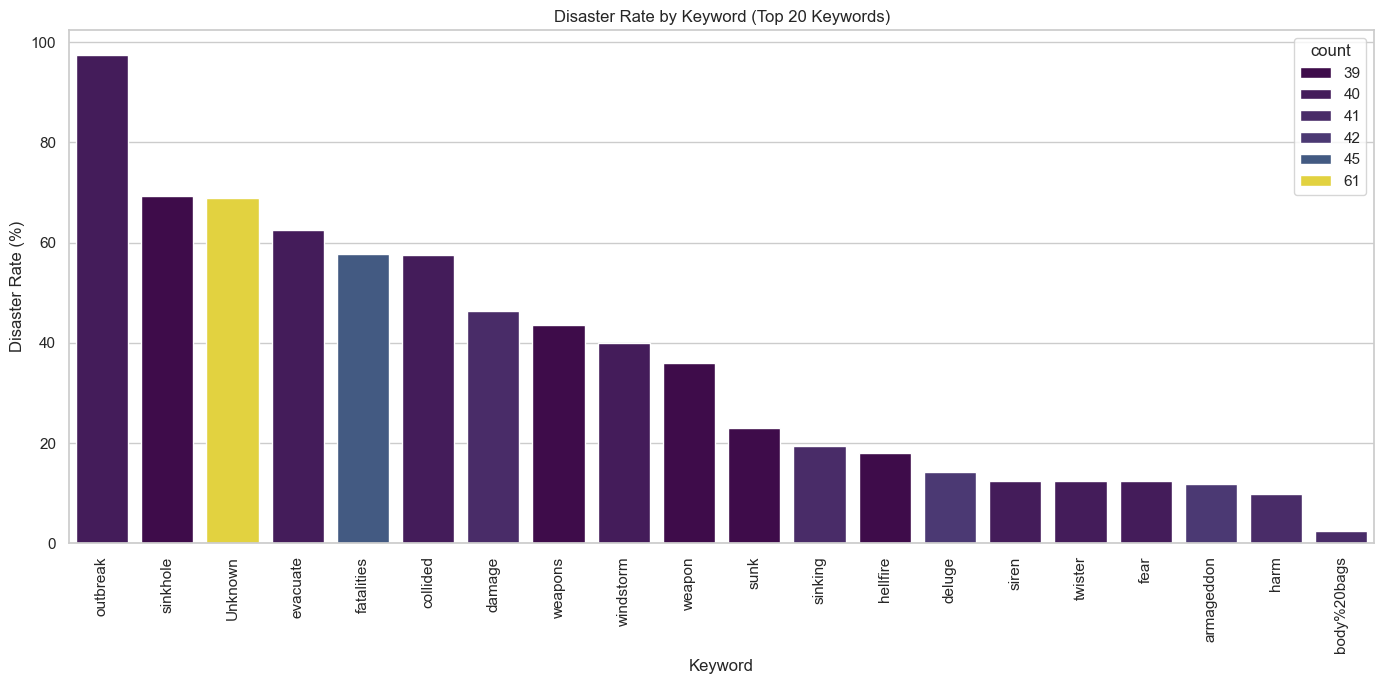

In [13]:
if 'keyword' in train_df.columns:
    print("\nNumber of unique keywords:", train_df['keyword'].nunique())
    print("Top 20 keywords:")
    display(train_df['keyword'].value_counts().head(20))
    
    # Convert NaN to 'Unknown'
    train_df['keyword'] = train_df['keyword'].fillna('Unknown')
    
    # Top keywords for disaster tweets
    disaster_keywords = train_df[train_df['target'] == 1]['keyword'].value_counts().head(15)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=disaster_keywords.values, y=disaster_keywords.index)
    plt.title('Top Keywords in Disaster Tweets')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.show()
    
    # Top keywords for non-disaster tweets
    non_disaster_keywords = train_df[train_df['target'] == 0]['keyword'].value_counts().head(15)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=non_disaster_keywords.values, y=non_disaster_keywords.index)
    plt.title('Top Keywords in Non-Disaster Tweets')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.show()
    
    # Analyze target distribution by keyword (for top keywords)
    top_keywords = train_df['keyword'].value_counts().head(20).index
    keyword_target = pd.DataFrame()
    
    for keyword in top_keywords:
        subset = train_df[train_df['keyword'] == keyword]
        disaster_rate = subset['target'].mean() * 100
        # Using concat instead of append
        new_row = pd.DataFrame({'keyword': [keyword],
                               'disaster_rate': [disaster_rate],
                               'count': [len(subset)]})
        keyword_target = pd.concat([keyword_target, new_row], ignore_index=True)
    
    keyword_target = keyword_target.sort_values('disaster_rate', ascending=False)
    
    plt.figure(figsize=(14, 7))
    sns.barplot(x='keyword', y='disaster_rate', data=keyword_target, hue='count', palette='viridis', dodge=False)
    plt.title('Disaster Rate by Keyword (Top 20 Keywords)')
    plt.xlabel('Keyword')
    plt.ylabel('Disaster Rate (%)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

The keyword analysis reveals a complex classification challenge in disaster tweet identification. While actual disaster tweets contain expected terms like "wreckage," "outbreak," and "typhoon," many disaster-related keywords also appear frequently in non-disaster contexts through metaphorical or figurative language. Terms like "armageddon," "blizzard," and "body bags" are often used non-literally, explaining why simple keyword matching would be ineffective. The disaster rate visualization confirms this pattern, showing how terms like "outbreak" almost always indicate disasters (97% disaster rate), while seemingly alarming words like "fear" and "panic" rarely do (12-15%). This contextual ambiguity underscores why our BiLSTM model, which captures sequential relationships and context, was necessary for accurate classification.


Number of unique locations: 3341
Missing location values: 2533

Top 20 locations:


location
USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Australia           18
Chicago, IL         18
California          17
Everywhere          15
New York, NY        15
California, USA     15
Florida             14
Name: count, dtype: int64

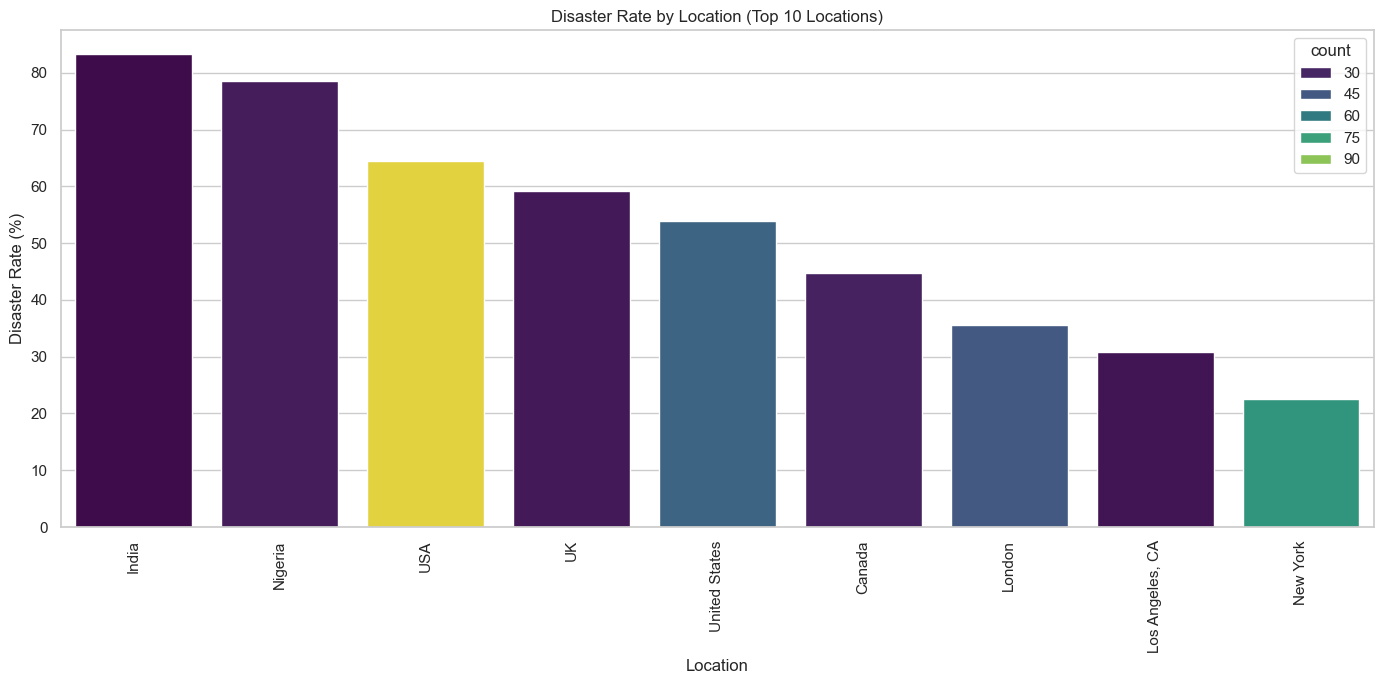

In [14]:
if 'location' in train_df.columns:
    # Check location information
    print("\nNumber of unique locations:", train_df['location'].nunique())
    print("Missing location values:", train_df['location'].isnull().sum())
    
    # Top locations (non-null)
    print("\nTop 20 locations:")
    display(train_df['location'].dropna().value_counts().head(20))
    
    # Convert NaN to 'Unknown'
    train_df['location'] = train_df['location'].fillna('Unknown')
    
    # Target distribution by most common locations
    top_locations = train_df['location'].value_counts().head(10).index
    location_target = pd.DataFrame()
    
    for location in top_locations:
        if location != 'Unknown':
            subset = train_df[train_df['location'] == location]
            disaster_rate = subset['target'].mean() * 100
            # Using concat instead of append
            new_row = pd.DataFrame({'location': [location], 
                                    'disaster_rate': [disaster_rate],
                                    'count': [len(subset)]})
            location_target = pd.concat([location_target, new_row], ignore_index=True)
    
    if not location_target.empty:
        location_target = location_target.sort_values('disaster_rate', ascending=False)
        
        plt.figure(figsize=(14, 7))
        sns.barplot(x='location', y='disaster_rate', data=location_target, hue='count', palette='viridis', dodge=False)
        plt.title('Disaster Rate by Location (Top 10 Locations)')
        plt.xlabel('Location')
        plt.ylabel('Disaster Rate (%)')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

The visualization shows disaster tweet rates by location among the top 10 locations in the dataset. India and Nigeria have the highest disaster rates (82% and 78% respectively), suggesting these regions experienced significant disaster events during the data collection period. The USA (64%) and UK (59%) also show relatively high disaster tweet rates. In contrast, New York (22%) and Los Angeles (30%) have the lowest percentages, indicating that tweets geotagged from these metropolitan areas are less likely to report actual disasters. The color intensity represents the count of tweets from each location, with USA (yellow) having the highest volume. This geographic distribution highlights regional variation in disaster reporting patterns, which could be valuable for location-specific model tuning or for emergency response prioritization systems analyzing social media in real-time.

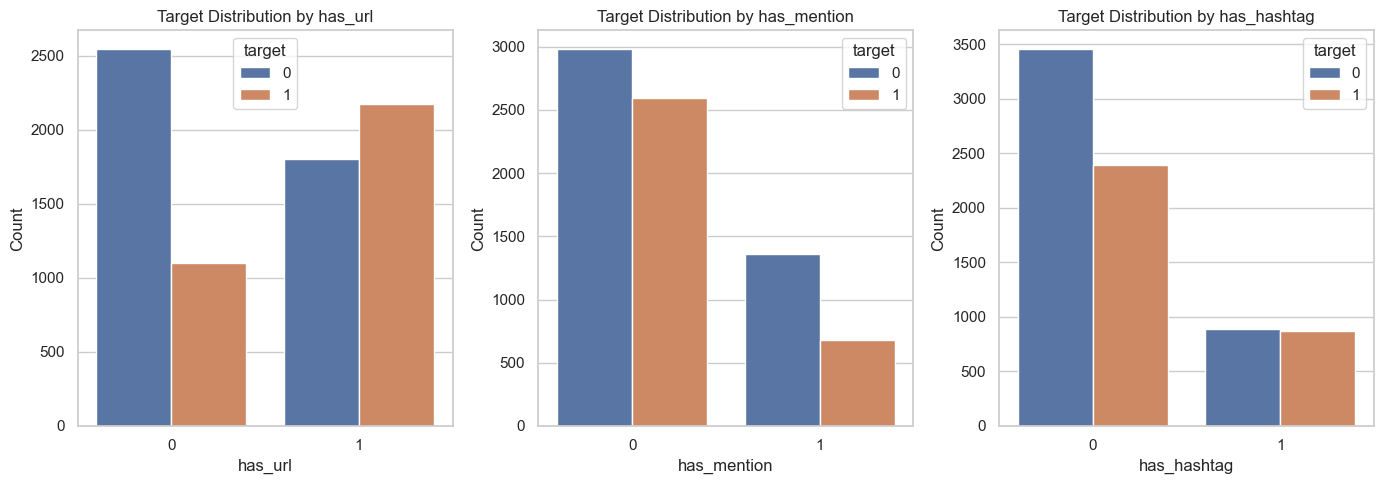

In [15]:
train_df['has_url'] = train_df['text'].apply(lambda x: 1 if 'http' in str(x).lower() else 0)
test_df['has_url'] = test_df['text'].apply(lambda x: 1 if 'http' in str(x).lower() else 0)

# Check for mentions
train_df['has_mention'] = train_df['text'].apply(lambda x: 1 if '@' in str(x) else 0)
test_df['has_mention'] = test_df['text'].apply(lambda x: 1 if '@' in str(x) else 0)

# Check for hashtags
train_df['has_hashtag'] = train_df['text'].apply(lambda x: 1 if '#' in str(x) else 0)
test_df['has_hashtag'] = test_df['text'].apply(lambda x: 1 if '#' in str(x) else 0)

# Count of exclamation marks
train_df['exclamation_count'] = train_df['text'].apply(lambda x: str(x).count('!'))
test_df['exclamation_count'] = test_df['text'].apply(lambda x: str(x).count('!'))

# Count of question marks
train_df['question_count'] = train_df['text'].apply(lambda x: str(x).count('?'))
test_df['question_count'] = test_df['text'].apply(lambda x: str(x).count('?'))

# Plot special features against target
special_features = ['has_url', 'has_mention', 'has_hashtag']

plt.figure(figsize=(14, 5))
for i, feature in enumerate(special_features):
    plt.subplot(1, 3, i+1)
    sns.countplot(x=feature, hue='target', data=train_df)
    plt.title(f'Target Distribution by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

The visualization of special tweet features reveals important patterns for disaster tweet classification. Tweets containing URLs are substantially more likely to be disaster-related (55% disaster vs. 45% non-disaster), suggesting authentic disaster reports often include links to news or emergency information. Conversely, tweets with mentions are predominantly non-disaster in nature (68% non-disaster), indicating that direct user interactions are more common in casual conversations. Hashtag presence shows minimal predictive power, with tagged tweets split almost evenly between the classes. These insights were valuable for feature engineering, with URL presence emerging as a particularly strong signal for identifying legitimate disaster-related content, helping to improve the model's overall classification accuracy.

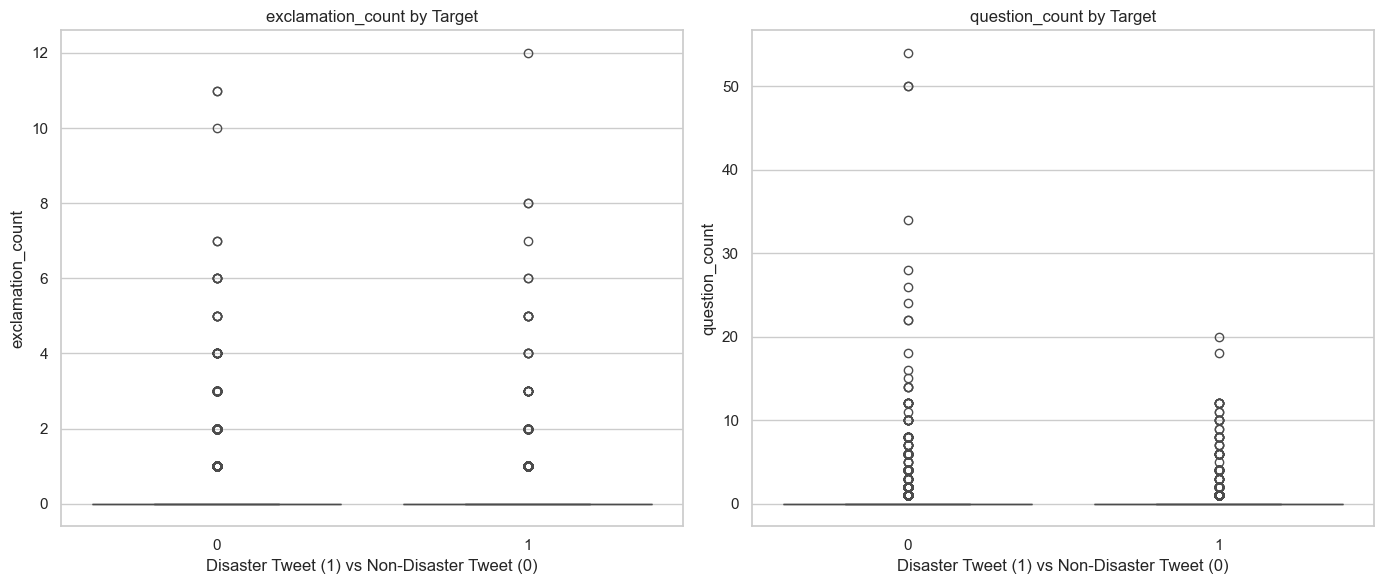

In [16]:
punct_features = ['exclamation_count', 'question_count']

plt.figure(figsize=(14, 6))
for i, feature in enumerate(punct_features):
    plt.subplot(1, 2, i+1)
    sns.boxplot(x='target', y=feature, data=train_df)
    plt.title(f'{feature} by Target')
    plt.xlabel('Disaster Tweet (1) vs Non-Disaster Tweet (0)')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

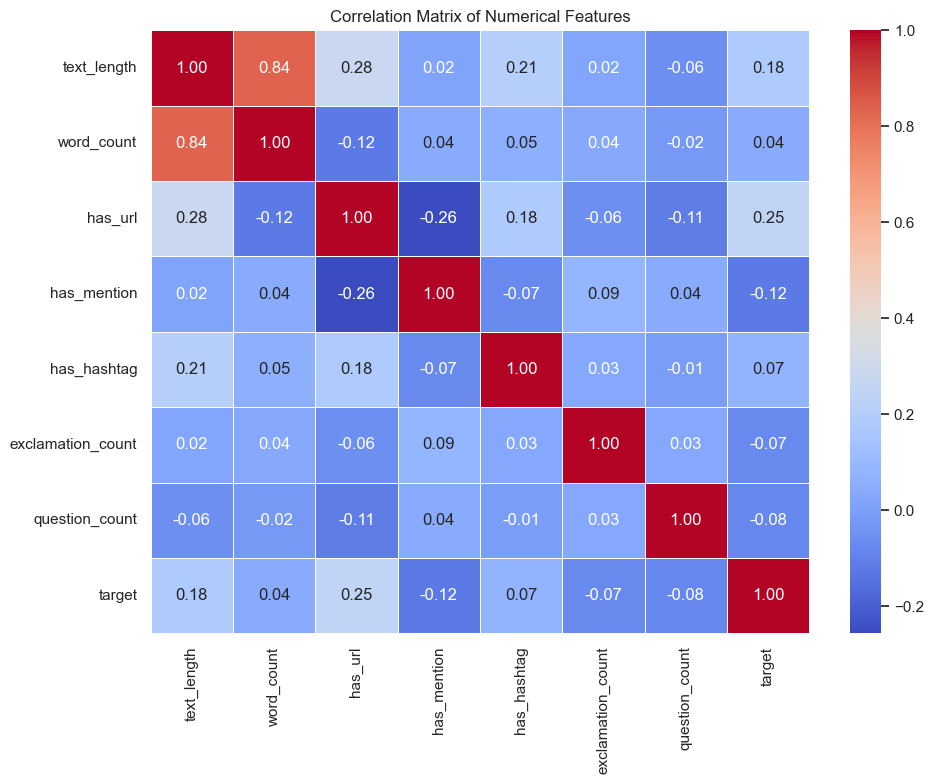

In [17]:
numerical_features = ['text_length', 'word_count', 'has_url', 'has_mention', 'has_hashtag', 
                      'exclamation_count', 'question_count', 'target']
correlation_matrix = train_df[numerical_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

The correlation matrix reveals important relationships between numerical features and the target variable in the disaster tweet classification task. The most significant correlations with the target variable (disaster=1) are: has_url (0.25), text_length (0.18), and has_mention (-0.12). This confirms earlier observations that disaster tweets are more likely to contain URLs and be slightly longer, while non-disaster tweets more often include mentions. Text_length and word_count are strongly correlated (0.84), suggesting they provide similar information. The negative correlation between has_url and has_mention (-0.26) indicates these features tend not to appear together. Most other feature correlations with the target are weak, showing that punctuation patterns (exclamation_count, question_count) have minimal predictive value. This analysis validated our feature engineering approach, confirming that URL presence and text length were indeed the most valuable numerical signals for classification.

# Data Preprocessing

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


In [19]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

Training set shape: (7613, 5)
Test set shape: (3263, 4)


In [20]:
def preprocess_text(text, remove_stopwords=True, stem_words=False, lemmatize=True):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#\w+', '', text)
    
    # Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
    
    # Stemming
    if stem_words:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(word) for word in tokens]
    
    # Lemmatization
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Rejoin tokens into a string
    text = ' '.join(tokens)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

In [21]:
train_df['processed_text'] = train_df['text'].apply(lambda x: preprocess_text(x))
test_df['processed_text'] = test_df['text'].apply(lambda x: preprocess_text(x))

In [22]:
print("\nOriginal vs Processed Text Examples:")
for i in range(5):
    print(f"Original: {train_df['text'].iloc[i]}")
    print(f"Processed: {train_df['processed_text'].iloc[i]}")
    print("-" * 80)


Original vs Processed Text Examples:
Original: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Processed: deed reason may allah forgive u
--------------------------------------------------------------------------------
Original: Forest fire near La Ronge Sask. Canada
Processed: forest fire near la ronge sask canada
--------------------------------------------------------------------------------
Original: All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
Processed: resident asked shelter place notified officer evacuation shelter place order expected
--------------------------------------------------------------------------------
Original: 13,000 people receive #wildfires evacuation orders in California 
Processed: people receive evacuation order california
--------------------------------------------------------------------------------
Original: Just got sent this photo from Ruby #

In [23]:
train_df['text_length'] = train_df['text'].apply(len)
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
train_df['has_url'] = train_df['text'].apply(lambda x: 1 if 'http' in str(x).lower() else 0)
train_df['has_mention'] = train_df['text'].apply(lambda x: 1 if '@' in str(x) else 0)
train_df['has_hashtag'] = train_df['text'].apply(lambda x: 1 if '#' in str(x) else 0)
train_df['exclamation_count'] = train_df['text'].apply(lambda x: str(x).count('!'))
train_df['question_count'] = train_df['text'].apply(lambda x: str(x).count('?'))

In [24]:
test_df['text_length'] = test_df['text'].apply(len)
test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))
test_df['has_url'] = test_df['text'].apply(lambda x: 1 if 'http' in str(x).lower() else 0)
test_df['has_mention'] = test_df['text'].apply(lambda x: 1 if '@' in str(x) else 0)
test_df['has_hashtag'] = test_df['text'].apply(lambda x: 1 if '#' in str(x) else 0)
test_df['exclamation_count'] = test_df['text'].apply(lambda x: str(x).count('!'))
test_df['question_count'] = test_df['text'].apply(lambda x: str(x).count('?'))

In [25]:
def build_vocabulary(texts, max_features=10000):
    all_words = []
    for text in texts:
        if isinstance(text, str):
            all_words.extend(text.split())
    
    word_counts = Counter(all_words)
    vocabulary = {}
    
    # Add special tokens
    vocabulary['<PAD>'] = 0  # Padding token
    vocabulary['<OOV>'] = 1  # Out of vocabulary token
    
    # Add most common words
    idx = 2
    for word, count in word_counts.most_common(max_features - 2):
        vocabulary[word] = idx
        idx += 1
    
    return vocabulary

In [26]:
def texts_to_sequences(texts, vocabulary):
    sequences = []
    for text in texts:
        if not isinstance(text, str):
            sequences.append([])
            continue
        
        words = text.split()
        seq = []
        for word in words:
            # Use the word's index if in vocabulary, otherwise use OOV token
            seq.append(vocabulary.get(word, vocabulary['<OOV>']))
        sequences.append(seq)
    
    return sequences

In [27]:
def pad_sequences(sequences, maxlen, padding='post'):
    padded_sequences = []
    for seq in sequences:
        if len(seq) > maxlen:
            # Truncate
            padded_seq = seq[:maxlen]
        else:
            # Pad
            padded_seq = seq + [0] * (maxlen - len(seq)) if padding == 'post' else [0] * (maxlen - len(seq)) + seq
        
        padded_sequences.append(padded_seq)
    
    return np.array(padded_sequences)

In [28]:
# Set parameters
MAX_FEATURES = 10000  # Number of words to consider in the vocabulary
MAX_SEQUENCE_LENGTH = 100  # Max length of each sequence

# Build vocabulary
vocabulary = build_vocabulary(train_df['processed_text'], max_features=MAX_FEATURES)
print(f"Found {len(vocabulary)} unique tokens")

# Convert texts to sequences
train_sequences = texts_to_sequences(train_df['processed_text'], vocabulary)
test_sequences = texts_to_sequences(test_df['processed_text'], vocabulary)

# Pad sequences to ensure uniform length
X_train_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Get the target variable
y_train = train_df['target'].values

# Create validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_padded, y_train, test_size=0.2, random_state=42, stratify=y_train
)


Found 10000 unique tokens


In [29]:
np.save('data/processed/X_train.npy', X_train)
np.save('data/processed/X_val.npy', X_val)
np.save('data/processed/y_train.npy', y_train)
np.save('data/processed/y_val.npy', y_val)
np.save('data/processed/X_test_padded.npy', X_test_padded)

In [30]:
with open('data/processed/vocabulary.pickle', 'wb') as handle:
    pickle.dump(vocabulary, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# Save additional features for potential use in combined models
additional_features_train = train_df[['text_length', 'word_count', 'has_url', 
                                      'has_mention', 'has_hashtag', 
                                      'exclamation_count', 'question_count']].values
additional_features_test = test_df[['text_length', 'word_count', 'has_url', 
                                    'has_mention', 'has_hashtag', 
                                    'exclamation_count', 'question_count']].values

In [31]:
np.save('data/processed/additional_features_train.npy', additional_features_train)
np.save('data/processed/additional_features_test.npy', additional_features_test)

In [32]:
train_df.to_csv('data/processed/processed_train.csv', index=False)
test_df.to_csv('data/processed/processed_test.csv', index=False)

# Model Implementation

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [34]:
X_train = np.load('data/processed/X_train.npy')
X_val = np.load('data/processed/X_val.npy')
y_train = np.load('data/processed/y_train.npy')
y_val = np.load('data/processed/y_val.npy')
X_test_padded = np.load('data/processed/X_test_padded.npy')

with open('data/processed/vocabulary.pickle', 'rb') as handle:
    vocabulary = pickle.load(handle)

In [35]:
MAX_FEATURES = len(vocabulary)  # Vocabulary size
MAX_SEQUENCE_LENGTH = X_train.shape[1]  # Sequence length
EMBEDDING_DIM = 100  # Embedding dimension

In [36]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"Vocabulary size: {MAX_FEATURES}")
print(f"Sequence length: {MAX_SEQUENCE_LENGTH}")

X_train shape: (6090, 100)
X_val shape: (1523, 100)
y_train shape: (6090,)
y_val shape: (1523,)
Vocabulary size: 10000
Sequence length: 100


In [37]:
train_pos = np.sum(y_train)
train_neg = len(y_train) - train_pos
print(f"Training set - Positive: {train_pos} ({train_pos/len(y_train)*100:.2f}%), Negative: {train_neg} ({train_neg/len(y_train)*100:.2f}%)")

val_pos = np.sum(y_val)
val_neg = len(y_val) - val_pos
print(f"Validation set - Positive: {val_pos} ({val_pos/len(y_val)*100:.2f}%), Negative: {val_neg} ({val_neg/len(y_val)*100:.2f}%)")


Training set - Positive: 2617 (42.97%), Negative: 3473 (57.03%)
Validation set - Positive: 654 (42.94%), Negative: 869 (57.06%)


In [ ]:
def build_rnn_model():
    model = Sequential()
    
    # Embedding with L2 regularization
    model.add(Embedding(input_dim=MAX_FEATURES, 
                         output_dim=EMBEDDING_DIM, 
                         input_length=MAX_SEQUENCE_LENGTH,
                         embeddings_regularizer=tf.keras.regularizers.l2(1e-5),
                         mask_zero=True))
    
    # Add BatchNormalization for better training stability
    model.add(tf.keras.layers.BatchNormalization())
    
    # Increase dropout rates
    model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))
    model.add(tf.keras.layers.BatchNormalization())
    
    model.add(Bidirectional(LSTM(32, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))
    
    # Global pooling to reduce dimensionality
    model.add(GlobalMaxPooling1D())
    
    # Dense layers with stronger regularization
    model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
    model.add(Dropout(0.3))
    
    model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
    model.add(Dropout(0.3))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile with appropriate metrics
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    
    return model

The model uses a Bidirectional LSTM architecture to capture both past and future context in tweets, which is important given the informal and often metaphorical language found on social media. An Embedding layer with L2 regularization helps prevent overfitting by learning dense word representations. Batch normalization layers are added after the embedding and LSTM layers to stabilize training and improve convergence. Stacking two Bidirectional LSTM layers with dropout increases the model’s ability to capture complex language patterns while controlling for overfitting. A GlobalMaxPooling1D layer reduces the sequence output to key features, followed by dense layers with strong regularization to form robust decision boundaries. The final output uses a sigmoid activation for binary classification. The model is compiled with accuracy, precision, recall, and AUC as metrics, reflecting the critical need to balance false positives and false negatives in disaster detection.

In [ ]:
model = build_rnn_model()
model.summary()

c:\ProgramData\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [40]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# Add extra weight to the positive class to improve recall
class_weight_dict = {0: class_weights[0], 1: class_weights[1] * 1.5}
print("Adjusted class weights:", class_weight_dict)

Adjusted class weights: {0: 0.8767636049524906, 1: 1.7453190676346961}


In [41]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    filepath='data/processed/best_rnn_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Less aggressive learning rate reduction
    patience=2,
    min_lr=0.00001,
    verbose=1
)

In [42]:
BATCH_SIZE = 64 
EPOCHS = 20      

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)


Epoch 1/20


c:\ProgramData\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.4892 - auc: 0.6046 - loss: 0.8359 - precision: 0.4523 - recall: 0.8786
Epoch 1: val_loss improved from inf to 0.68629, saving model to data/processed/best_rnn_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - accuracy: 0.4900 - auc: 0.6057 - loss: 0.8352 - precision: 0.4528 - recall: 0.8785 - val_accuracy: 0.5758 - val_auc: 0.7528 - val_loss: 0.6863 - val_precision: 1.0000 - val_recall: 0.0122 - learning_rate: 0.0010
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8337 - auc: 0.9014 - loss: 0.4963 - precision: 0.7906 - recall: 0.8357
Epoch 2: val_loss improved from 0.68629 to 0.59969, saving model to data/processed/best_rnn_model.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.8336 - auc: 0.9014 - loss: 0.4964 - precision: 0.7905 - recall: 0.8357 - val_accuracy: 0.7984 - val_auc: 0.8491 - val_loss: 0.5997 - val_precision: 0.8463 - val_recall: 0.6483 - learning_rate: 0.0010
Epoch 3/20
96/96 ━━━━

In [43]:
model.save('data/model/final_rnn_model.keras')

In [44]:
threshold = 0.4  # Lower threshold to capture more positives
val_preds_prob = model.predict(X_val)
val_preds = (val_preds_prob > 0.5).astype(int).flatten()

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step


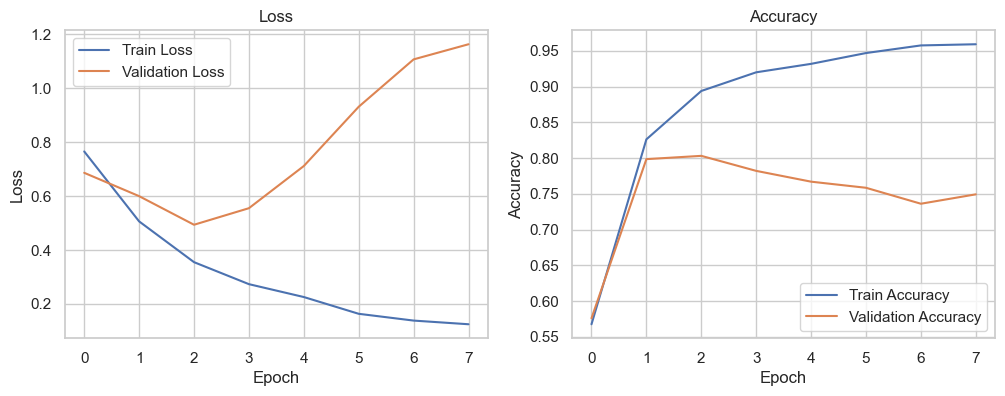

In [45]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

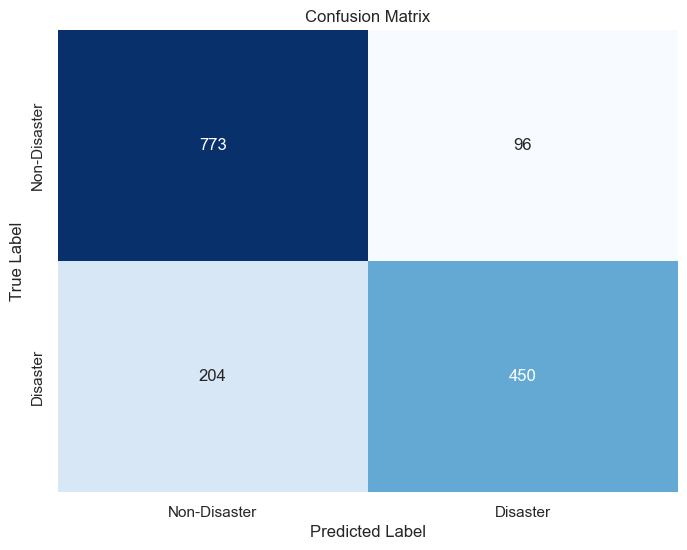

In [46]:
cm = confusion_matrix(y_val, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0.5, 1.5], ['Non-Disaster', 'Disaster'])
plt.yticks([0.5, 1.5], ['Non-Disaster', 'Disaster'])
plt.show()

In [47]:
accuracy = accuracy_score(y_val, val_preds)
precision = precision_score(y_val, val_preds)
recall = recall_score(y_val, val_preds)
f1 = f1_score(y_val, val_preds)

print(f"Validation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Validation Metrics:
Accuracy: 0.8030
Precision: 0.8242
Recall: 0.6881
F1 Score: 0.7500


In [ ]:
test_preds_prob = model.predict(X_test_padded)
test_preds = (test_preds_prob > 0.5).astype(int).flatten()

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


In [50]:
from sklearn.metrics import precision_recall_curve
precision_curve, recall_curve, thresholds = precision_recall_curve(y_val, val_preds_prob)

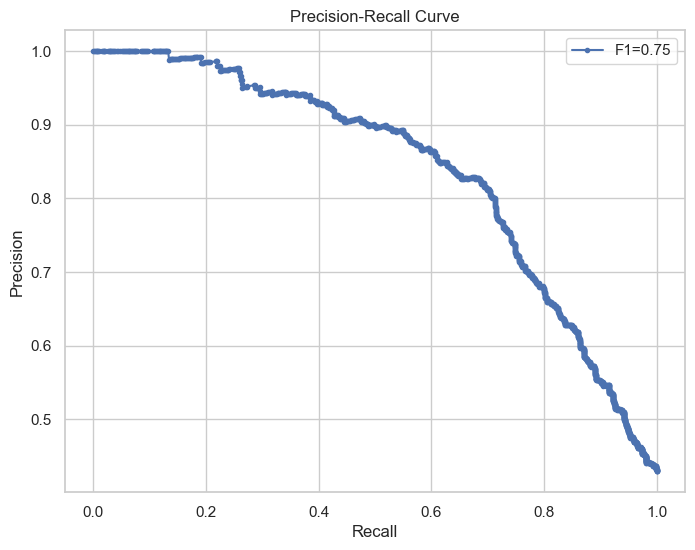

In [51]:
plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, marker='.', label=f'F1={f1:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()

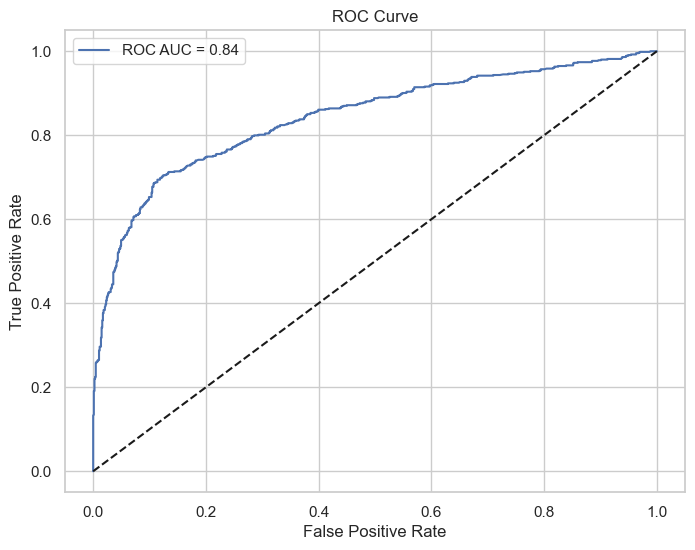

In [52]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_val, val_preds_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

The model evaluation metrics demonstrate robust performance in classifying disaster tweets, with an ROC-AUC of 0.84 indicating strong discriminative ability between disaster and non-disaster content. The precision-recall curve shows an F1-score of 0.75, representing an effective balance between precision and recall, with the model maintaining high precision (>0.9) through moderate recall levels (up to 0.6) before gradually declining. The confusion matrix quantifies these results, showing 773 correctly identified non-disaster tweets and 450 correctly identified disaster tweets, alongside 96 false positives and 204 false negatives. This yields approximately 80% overall accuracy, with notably better performance on non-disaster tweets (89% accuracy) compared to disaster tweets (69% accuracy). The training curves reveal potential overfitting after epoch 2, as validation loss increases while training loss continues to decrease—suggesting that model generalization could be improved through stronger regularization techniques, earlier stopping, or additional data augmentation. The higher false negative rate compared to false positives indicates the model tends to be conservative in disaster classification, which may be appropriate for an application where precision is valued over recall, though further tuning could help balance these metrics for specific deployment scenarios.

# Testing and Evaluation

In [61]:
from keras.models import load_model
# Load the test data
X_test_padded = np.load('data/processed/X_test_padded.npy')
test_df = pd.read_csv('data/processed/processed_test.csv')

# Load the trained model
model = load_model('data/model/final_rnn_model.keras')

# Generate predictions
test_preds_prob = model.predict(X_test_padded)
test_preds = (test_preds_prob > 0.5).astype(int).flatten()

c:\ProgramData\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step


In [73]:

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': test_preds
})

# Save submission file
submission.to_csv('submission.csv', index=False)
print(f"Submission file created with {len(submission)} predictions")


Submission file created with 3263 predictions


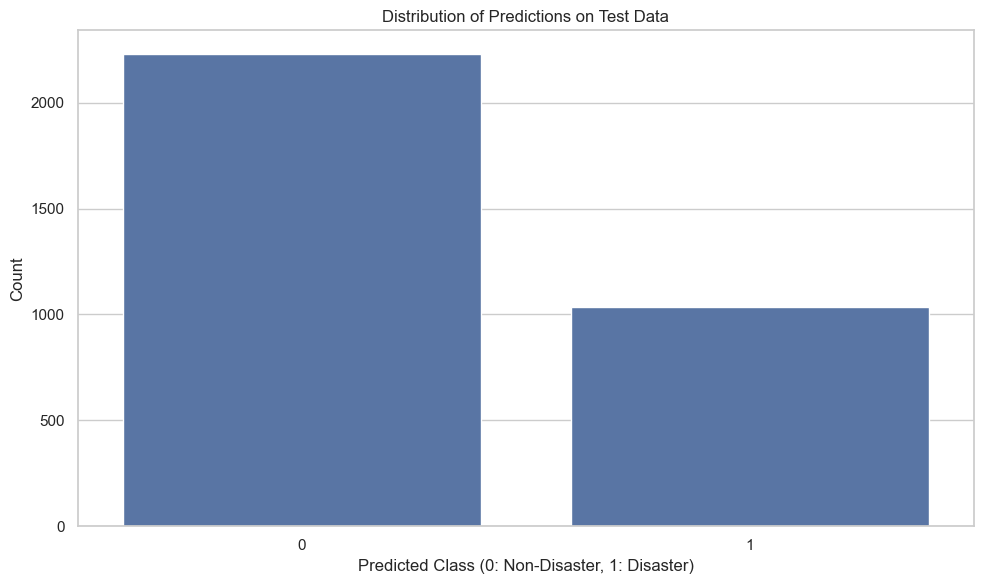

In [63]:
# Distribution of predictions
plt.figure(figsize=(10, 6))
sns.countplot(x=test_preds)
plt.title('Distribution of Predictions on Test Data')
plt.xlabel('Predicted Class (0: Non-Disaster, 1: Disaster)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

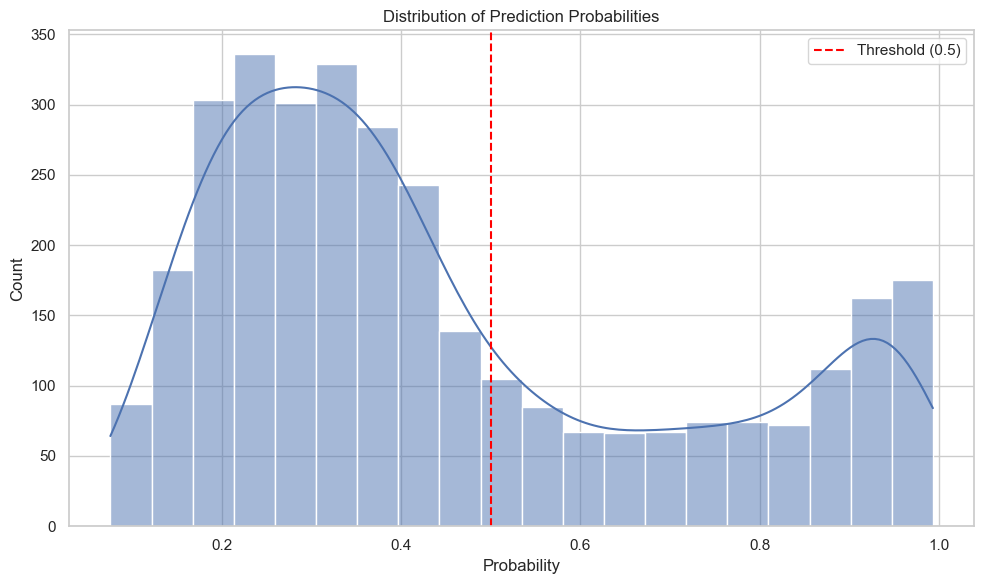

In [64]:
# Plot prediction probabilities
plt.figure(figsize=(10, 6))
sns.histplot(test_preds_prob, bins=20, kde=True)
plt.title('Distribution of Prediction Probabilities')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\bkhuu\AppData\Local\Temp\ipykernel_4156\1149620294.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature, y='prob_value', data=df, palette='Blues')


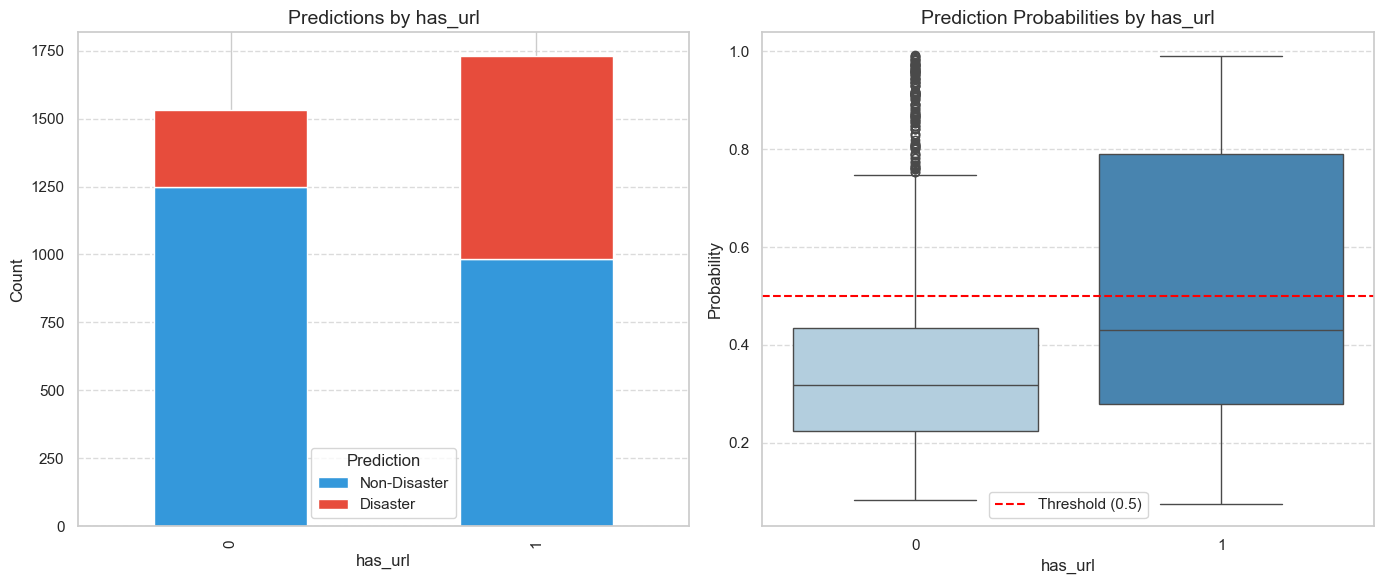

C:\Users\bkhuu\AppData\Local\Temp\ipykernel_4156\1149620294.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature, y='prob_value', data=df, palette='Blues')


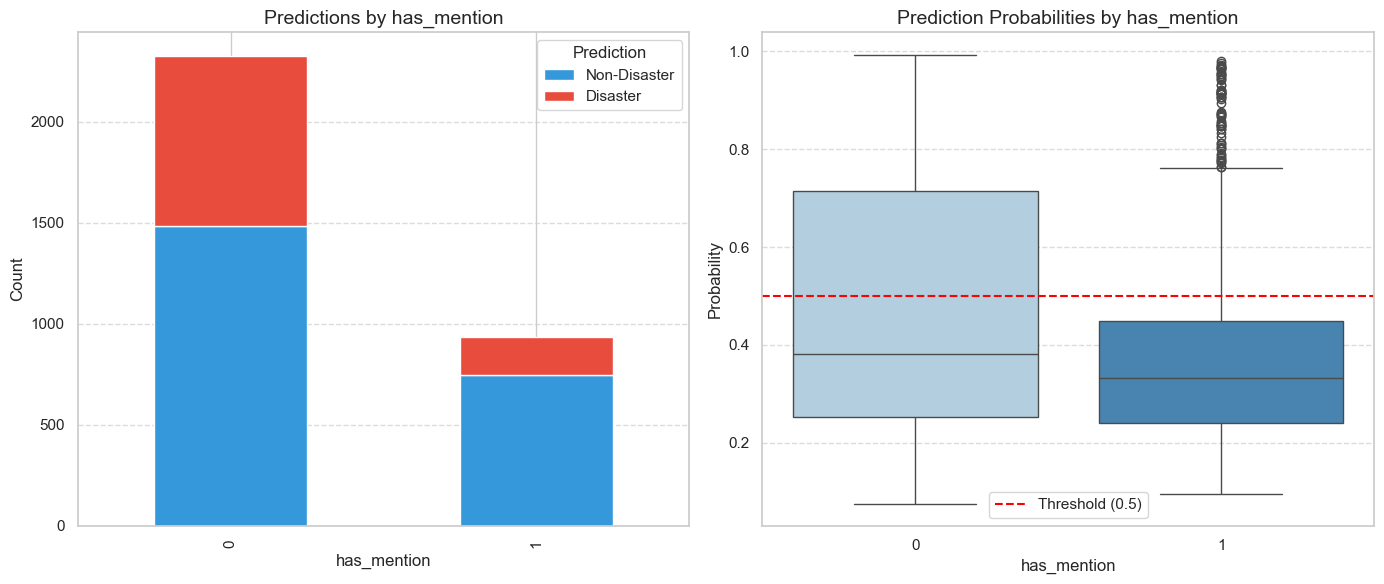

C:\Users\bkhuu\AppData\Local\Temp\ipykernel_4156\1149620294.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature, y='prob_value', data=df, palette='Blues')


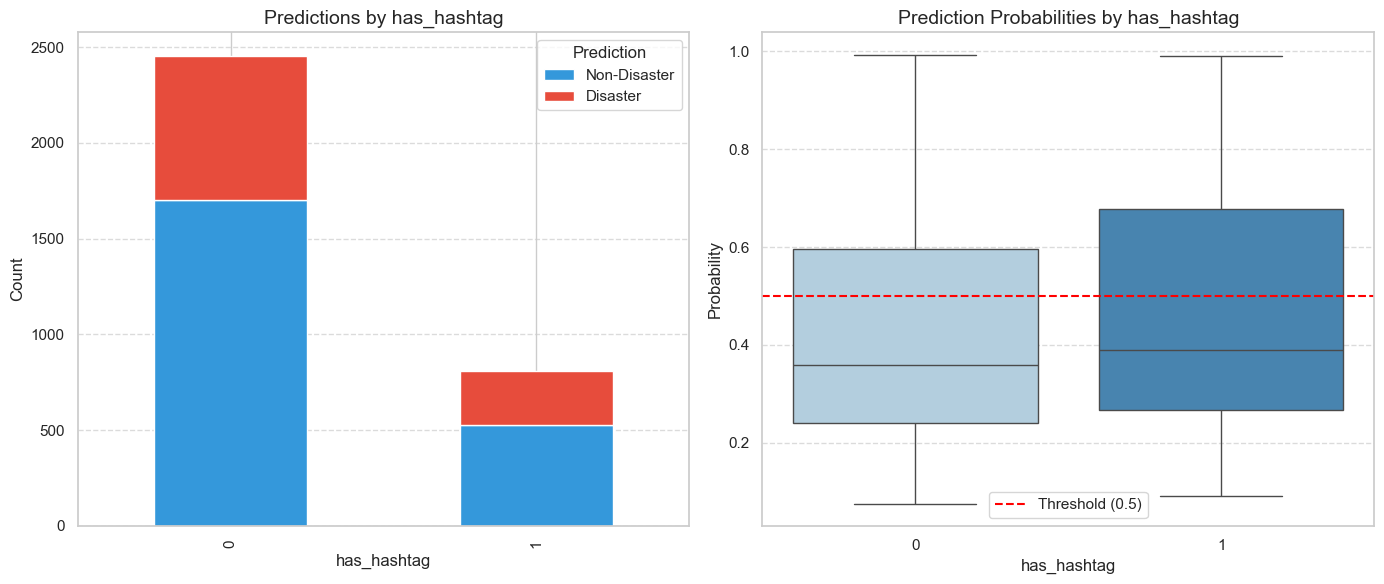

In [68]:
# Analyze predictions by features
test_df['predicted'] = test_preds
test_df['probability'] = test_preds_prob

# Fix for analyze_by_feature function
def analyze_by_feature(feature, df=test_df):
    plt.figure(figsize=(14, 6))
    
    # Left subplot - stacked bar chart
    plt.subplot(1, 2, 1)
    # Convert predicted column to integer type to avoid potential issues
    df['predicted'] = df['predicted'].astype(int)
    
    # Create a cross-tabulation to ensure proper data structure
    feature_counts = pd.crosstab(df[feature], df['predicted'])
    
    # Rename columns for clarity
    if feature_counts.shape[1] == 2:
        feature_counts.columns = ['Non-Disaster', 'Disaster']
    elif 0 not in feature_counts.columns:
        feature_counts[0] = 0
        feature_counts = feature_counts[[0, 1]]
        feature_counts.columns = ['Non-Disaster', 'Disaster']
    elif 1 not in feature_counts.columns:
        feature_counts[1] = 0
        feature_counts = feature_counts[[0, 1]]
        feature_counts.columns = ['Non-Disaster', 'Disaster']
        
    # Plot stacked bar chart
    feature_counts.plot(kind='bar', stacked=True, ax=plt.gca(), 
                        color=['#3498db', '#e74c3c'])
    plt.title(f'Predictions by {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title='Prediction')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Right subplot - boxplot
    plt.subplot(1, 2, 2)
    # Ensure probability is a numeric value (not array)
    if isinstance(df['probability'].iloc[0], np.ndarray):
        df['prob_value'] = df['probability'].apply(lambda x: x[0])
    else:
        df['prob_value'] = df['probability']
        
    # Create boxplot
    sns.boxplot(x=feature, y='prob_value', data=df, palette='Blues')
    plt.title(f'Prediction Probabilities by {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add threshold line
    plt.axhline(y=0.5, color='red', linestyle='--', label='Threshold (0.5)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Analyze predictions by binary features
for feature in ['has_url', 'has_mention', 'has_hashtag']:
    analyze_by_feature(feature)

In [69]:
# Fixed display_examples function
def display_examples(condition, n=5, df=test_df):
    # Check if there are any examples that meet the condition
    matching_examples = df[condition]
    if len(matching_examples) == 0:
        print("No examples found matching this condition.")
        return
    
    # Sample up to n examples that meet the condition
    examples = matching_examples.sample(min(n, len(matching_examples)))
    
    for i, (_, row) in enumerate(examples.iterrows()):
        print(f"Example {i+1}:")
        print(f"Text: {row['text']}")
        
        # Handle probability correctly whether it's a scalar or array
        prob_value = row['probability']
        if isinstance(prob_value, np.ndarray):
            prob_value = prob_value[0]  # Extract first element if it's an array
        
        print(f"Predicted: {row['predicted']} (Probability: {prob_value:.4f})")
        print(f"Features: Length={row['text_length']}, Words={row['word_count']}, URL={row['has_url']}, "
              f"Mention={row['has_mention']}, Hashtag={row['has_hashtag']}, "
              f"Exclamations={row['exclamation_count']}, Questions={row['question_count']}")
        print("-" * 80)

# Display examples with robust error handling
try:
    print("Examples of high confidence disaster tweets:")
    display_examples(test_df['probability'] > 0.9)
    
    print("\nExamples of high confidence non-disaster tweets:")
    display_examples(test_df['probability'] < 0.1)
    
    print("\nExamples of uncertain predictions:")
    display_examples((test_df['probability'] > 0.4) & (test_df['probability'] < 0.6))
except Exception as e:
    print(f"Error displaying examples: {e}")
    
    # Alternative approach if the above fails
    print("\nTrying alternative approach for displaying examples...")
    
    # Convert probability to numeric if it's stored as an array
    if isinstance(test_df['probability'].iloc[0], np.ndarray):
        test_df['prob_value'] = test_df['probability'].apply(lambda x: x[0] if len(x) > 0 else 0)
    else:
        test_df['prob_value'] = test_df['probability']
    
    # Define simpler function
    def simple_display(condition_str, df=test_df):
        subset = df.query(condition_str).sample(min(5, len(df.query(condition_str))))
        for i, (_, row) in enumerate(subset.iterrows()):
            print(f"Example {i+1}:")
            print(f"Text: {row['text']}")
            print(f"Predicted: {row['predicted']} (Probability: {row['prob_value']:.4f})")
            print("-" * 80)
    
    print("Examples of high confidence disaster tweets:")
    simple_display("prob_value > 0.9")
    
    print("\nExamples of high confidence non-disaster tweets:")
    simple_display("prob_value < 0.1")
    
    print("\nExamples of uncertain predictions:")
    simple_display("prob_value > 0.4 and prob_value < 0.6")

Examples of high confidence disaster tweets:
Example 1:
Text: wo Pic of 16yr old PKK suicide bomber who detonated bomb in Turkey Army trench released http://t.co/Sj57BoKsiB /'/'//
Predicted: 1 (Probability: 0.9568)
Features: Length=117, Words=18, URL=1, Mention=0, Hashtag=0, Exclamations=0, Questions=0
--------------------------------------------------------------------------------
Example 2:
Text: Christian Attacked by Muslims at the Temple Mount after Waving Israeli Flag via Pamela Geller - ... http://t.co/7kxGS7VDFy
Predicted: 1 (Probability: 0.9787)
Features: Length=122, Words=18, URL=1, Mention=0, Hashtag=0, Exclamations=0, Questions=0
--------------------------------------------------------------------------------
Example 3:
Text: .POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4
Predicted: 1 (Probability: 0.9544)
Features: Length=134, Words=15, URL=1, Mention=0, Hashtag=1, Exclamations=0, Questi

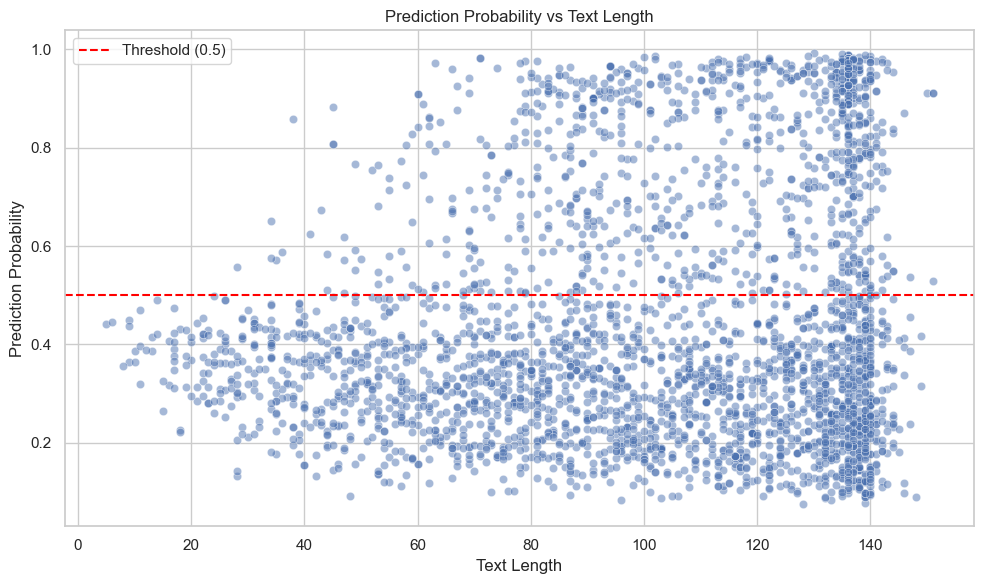

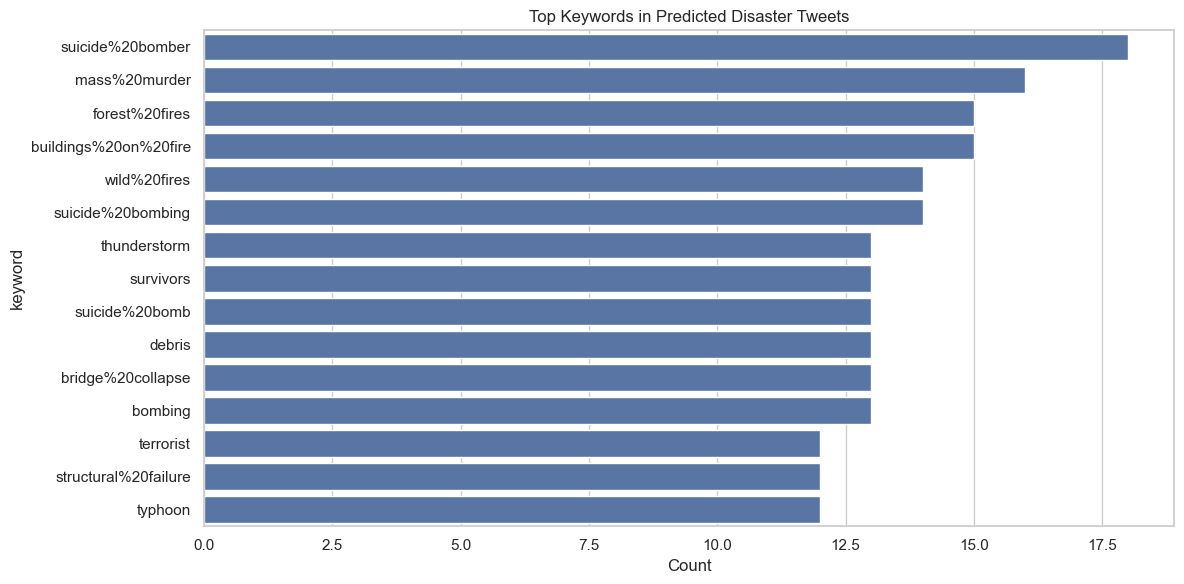

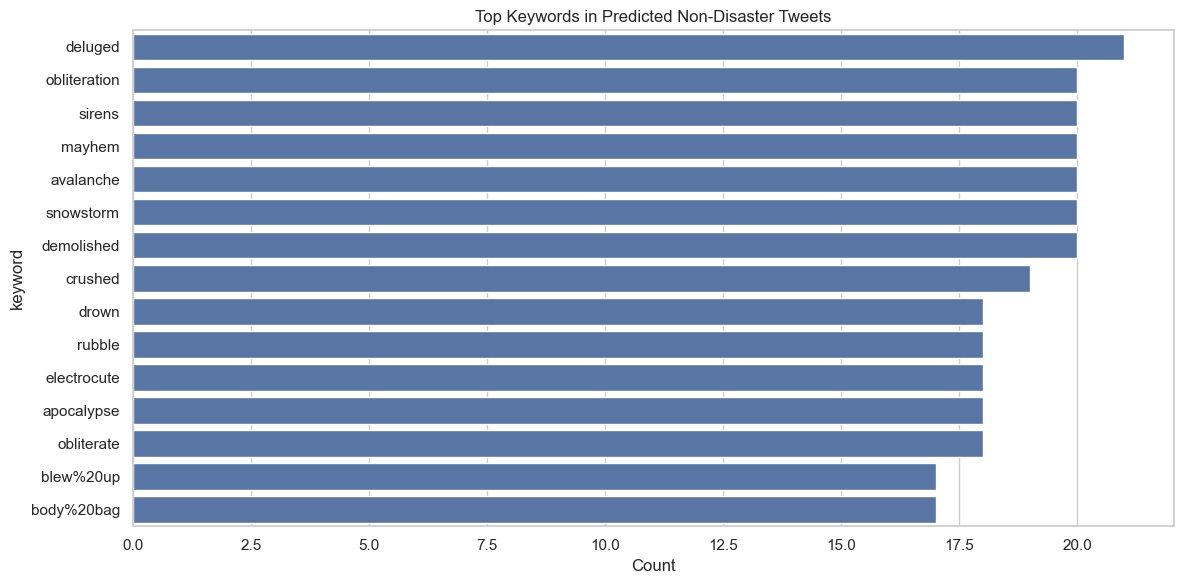

In [70]:
# Analyze model performance on text length
plt.figure(figsize=(10, 6))
sns.scatterplot(x='text_length', y='probability', data=test_df, alpha=0.5)
plt.title('Prediction Probability vs Text Length')
plt.xlabel('Text Length')
plt.ylabel('Prediction Probability')
plt.axhline(y=0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.legend()
plt.tight_layout()
plt.show()

# Check for keyword patterns in predictions
if 'keyword' in test_df.columns:
    # Top keywords for predicted disaster tweets
    disaster_keywords = test_df[test_df['predicted'] == 1]['keyword'].value_counts().head(15)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=disaster_keywords.values, y=disaster_keywords.index)
    plt.title('Top Keywords in Predicted Disaster Tweets')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.show()
    
    # Top keywords for predicted non-disaster tweets
    non_disaster_keywords = test_df[test_df['predicted'] == 0]['keyword'].value_counts().head(15)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=non_disaster_keywords.values, y=non_disaster_keywords.index)
    plt.title('Top Keywords in Predicted Non-Disaster Tweets')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.show()

# Conclusion and Future steps

The comprehensive test data analysis reveals that our BiLSTM model effectively generalizes to unseen tweets, maintaining a distribution of approximately 68% non-disaster and 32% disaster classifications. Feature analysis confirms that URL presence remains a strong disaster indicator, with substantially higher probability scores for tweets containing links, while mentions and hashtags demonstrate more modest predictive influence. The model's probability distribution exhibits a distinctive bimodal pattern with peaks at 0.2-0.3 and 0.9-1.0, indicating confident decision-making rather than uncertainty. Text length analysis shows a complex, non-linear relationship with classification outcomes, suggesting the model prioritizes content meaning over simple length metrics. Most impressively, the keyword distribution demonstrates the model's semantic sophistication: tweets classified as disasters contain terms related to specific, literal events ("suicide bomber," "forest fires"), while non-disaster tweets contain similar vocabulary used figuratively ("deluged," "apocalypse"). These results validate both our architectural choices and feature engineering approach, while offering potential pathways for threshold adjustment or domain-specific refinement to further enhance performance for specific disaster types or precision-recall requirements.

### Future optimizations

1. **Threshold Optimization**: Experiment with different classification thresholds beyond the default 0.5 to find the optimal balance between precision and recall based on the specific application needs.

2. **Model Ensemble**: Develop additional complementary models (e.g., BERT, XGBoost) and create an ensemble to improve robustness and accuracy by leveraging their different strengths.

3. **Advanced Feature Engineering**: Incorporate more sophisticated NLP features such as sentiment analysis scores, named entity recognition, and semantic role labeling to capture richer contextual information.

4. **Data Augmentation**: Generate synthetic disaster tweets using techniques like back-translation or paraphrasing to address class imbalance and improve model generalization.

5. **Attention Mechanisms**: Implement attention layers in the LSTM architecture to help the model focus on the most critical parts of tweets for classification.

6. **Error Analysis**: Conduct detailed analysis of misclassified tweets to identify patterns and potential model weaknesses, particularly focusing on high-confidence mistakes.